In [2]:
import pandas as pd
data =pd.read_csv("perfect_data.csv")
data

,High_BTC-USD,Low_BTC-USD,Open_BTC-USD,Volume_BTC-USD,actual_sentiment,closed
0,38225.906250,36658.761719,36931.546875,58598066402,0.7430,38144.308594
1,40846.546875,38138.386719,38138.386719,71326033653,-0.4898,39266.011719
2,39621.835938,37446.152344,39250.191406,65500641143,-0.3818,38903.441406
3,46203.929688,38076.324219,38886.828125,101467222687,0.9041,46196.464844
4,48003.722656,45166.960938,46184.992188,91809846886,0.2023,46481.105469
...,...,...,...,...,...,...
698,16964.585938,16667.763672,16680.205078,18421743322,-0.8561,16863.238281
699,16884.021484,16790.283203,16863.472656,13692758566,-0.3182,16836.736328
700,16991.994141,16716.421875,16836.472656,14413662913,-0.6249,16951.968750
701,16975.017578,16914.191406,16952.117188,7714767174,0.3612,16955.078125


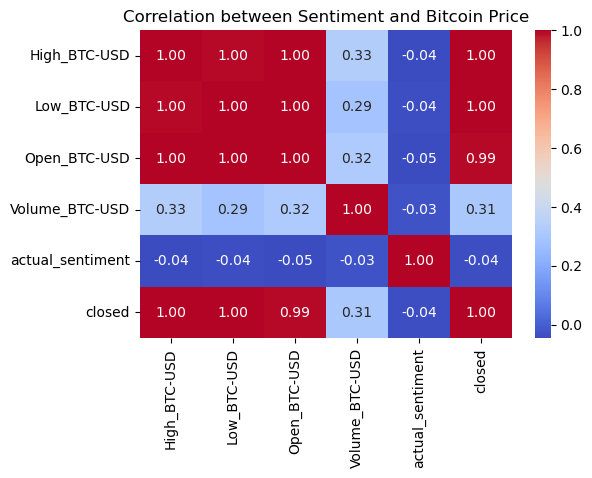

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the merged dataset
correlation = data.corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Sentiment and Bitcoin Price")
plt.show()

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Assuming `df` is your DataFrame
features = ['High_BTC-USD', 'Low_BTC-USD', 'Open_BTC-USD', 'Volume_BTC-USD', 'actual_sentiment']
target = 'closed'

# Scale features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[features + [target]])

# Convert to supervised LSTM format
window_size = 30
X, y = [], []

for i in range(window_size, len(scaled_features)):
    X.append(scaled_features[i - window_size:i, :-1])  # All features except 'Closed'
    y.append(scaled_features[i, -1])  # Only 'Closed'

X, y = np.array(X), np.array(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

C:\Users\Parth\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.1113 - val_loss: 0.0037
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0108 - val_loss: 4.4965e-04
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0094 - val_loss: 3.9548e-04
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0078 - val_loss: 8.8420e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0074 - val_loss: 5.5138e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0071 - val_loss: 2.9387e-04
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0057 - val_loss: 3.3543e-04
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0046 - val_loss: 2.5318e-04
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0052 - val_loss: 4.3162e-04
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0046 - val_loss: 2.6100e-04
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0042 - val_loss: 2.5813e-04
Epoch 12/50
34/34 ━━━━━

In [9]:
# Predict
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
# For this we need to pad the predictions back to full feature size for inverse_transform
pad_pred = np.hstack((np.zeros((predictions.shape[0], len(features))), predictions))
pad_actual = np.hstack((np.zeros((y_test.shape[0], len(features))), y_test.reshape(-1,1)))

predicted_prices = scaler.inverse_transform(pad_pred)[:, -1]
actual_prices = scaler.inverse_transform(pad_actual)[:, -1]


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Inverse transform both predictions and true values
y_test_scaled = y_test.reshape(-1, 1)
y_test_inv = scaler.inverse_transform(np.hstack((y_test_scaled, np.zeros((y_test_scaled.shape[0], data.shape[1] - 1)))))[:, 0]

# Metrics
mse = mean_squared_error(actual_prices,predicted_prices)
mae = mean_absolute_error(actual_prices,predicted_prices)
r2 = r2_score(actual_prices,predicted_prices)
rmse = np.sqrt(mse)

print("📊 LSTM Model Accuracy Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")


📊 LSTM Model Accuracy Metrics:
RMSE: 746.43
MAE: 554.16
R² Score: 0.7892


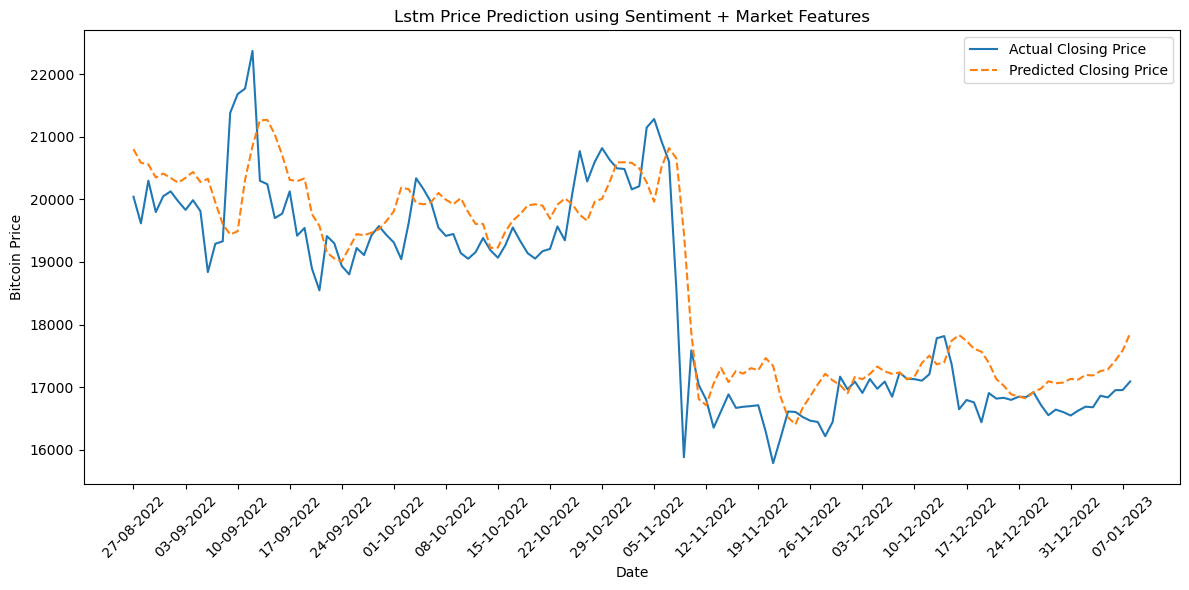

In [16]:
date = pd.read_csv('Date.csv')
date
pred_date=date.tail(135)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create DataFrame
df = pd.DataFrame({
    'Date': pred_date['Date'],
    'Actual Closing Price': actual_prices,
    'Predicted Closing Price': predicted_prices
})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Actual Closing Price'], label='Actual Closing Price')
plt.plot(df['Date'], df['Predicted Closing Price'], label='Predicted Closing Price', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.title('Lstm Price Prediction using Sentiment + Market Features')
plt.legend()

# Show fewer x-axis ticks (e.g., every 7 days)
step = 7  # Adjust this value as needed
plt.xticks(df['Date'][::step], rotation=45)

plt.tight_layout()
plt.show()